## Day 33 Lecture 2 Assignment

In this assignment, we will learn about non linear SVM models. We will use the heart disease dataset loaded below and analyze the model generated for this dataset.

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd

from sklearn.datasets import make_moons
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from mlxtend.plotting import plot_decision_regions
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
def print_vif(x):
    import warnings
    import statsmodels.api as sm
    from statsmodels.stats.outliers_influence import variance_inflation_factor

    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

<IPython.core.display.Javascript object>

In [4]:
heart = pd.read_csv(
    "https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/framingham_heart_disease.csv"
)

<IPython.core.display.Javascript object>

In [5]:
heart.shape

(4238, 16)

<IPython.core.display.Javascript object>

In [6]:
heart.head(20)

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0
5,0,43,2.0,0,0.0,0.0,0,1,0,228.0,180.0,110.0,30.30,77.0,99.0,0
6,0,63,1.0,0,0.0,0.0,0,0,0,205.0,138.0,71.0,33.11,60.0,85.0,1
7,0,45,2.0,1,20.0,0.0,0,0,0,313.0,100.0,71.0,21.68,79.0,78.0,0
8,1,52,1.0,0,0.0,0.0,0,1,0,260.0,141.5,89.0,26.36,76.0,79.0,0
9,1,43,1.0,1,30.0,0.0,0,1,0,225.0,162.0,107.0,23.61,93.0,88.0,0


<IPython.core.display.Javascript object>

In [7]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4238 non-null   int64  
 1   age              4238 non-null   int64  
 2   education        4133 non-null   float64
 3   currentSmoker    4238 non-null   int64  
 4   cigsPerDay       4209 non-null   float64
 5   BPMeds           4185 non-null   float64
 6   prevalentStroke  4238 non-null   int64  
 7   prevalentHyp     4238 non-null   int64  
 8   diabetes         4238 non-null   int64  
 9   totChol          4188 non-null   float64
 10  sysBP            4238 non-null   float64
 11  diaBP            4238 non-null   float64
 12  BMI              4219 non-null   float64
 13  heartRate        4237 non-null   float64
 14  glucose          3850 non-null   float64
 15  TenYearCHD       4238 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 529.9 KB


<IPython.core.display.Javascript object>

This dataset helps us predict the probability of coronary heart diease (CHD) in the next 10 years given the risk factors for each subject in the study. Our target variable is `TenYearCHD`.

We'll start off by removing any rows containing missing data.

In [8]:
# answer below:
heart = heart.dropna()
heart.isna().sum()


male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

<IPython.core.display.Javascript object>

In [9]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3656 entries, 0 to 4237
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             3656 non-null   int64  
 1   age              3656 non-null   int64  
 2   education        3656 non-null   float64
 3   currentSmoker    3656 non-null   int64  
 4   cigsPerDay       3656 non-null   float64
 5   BPMeds           3656 non-null   float64
 6   prevalentStroke  3656 non-null   int64  
 7   prevalentHyp     3656 non-null   int64  
 8   diabetes         3656 non-null   int64  
 9   totChol          3656 non-null   float64
 10  sysBP            3656 non-null   float64
 11  diaBP            3656 non-null   float64
 12  BMI              3656 non-null   float64
 13  heartRate        3656 non-null   float64
 14  glucose          3656 non-null   float64
 15  TenYearCHD       3656 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 485.6 KB


<IPython.core.display.Javascript object>

In [10]:
heart["TenYearCHD"].value_counts()

0    3099
1     557
Name: TenYearCHD, dtype: int64

<IPython.core.display.Javascript object>

Then, we split the data into train and test with 20% of the data in the test subset.

In [11]:
# answer below:
X = heart.drop(columns='TenYearCHD')
y = heart['TenYearCHD']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y )


<IPython.core.display.Javascript object>

In [12]:
print_vif(X)

VIF results
-------------------------------
const              195.466213
male                 1.205618
age                  1.360426
education            1.055117
currentSmoker        2.584703
cigsPerDay           2.732307
BPMeds               1.111192
prevalentStroke      1.017432
prevalentHyp         2.050782
diabetes             1.615855
totChol              1.116326
sysBP                3.766837
diaBP                3.000192
BMI                  1.239749
heartRate            1.093360
glucose              1.637353
dtype: float64
-------------------------------



<IPython.core.display.Javascript object>

In [13]:
y_train.value_counts()

0    2479
1     445
Name: TenYearCHD, dtype: int64

<IPython.core.display.Javascript object>

We will then scale the data using the standard scaler. Do this in the cell below.

In [14]:
heart.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


<IPython.core.display.Javascript object>

In [15]:
heart["BPMeds"].value_counts()

0.0    3545
1.0     111
Name: BPMeds, dtype: int64

<IPython.core.display.Javascript object>

In [16]:
# answer below:
num_cols = [
    'age',
    'cigsPerDay',
    'totChol',
    'sysBP',
    'diaBP',
    'BMI',
    'heartRate',
    'glucose',
    'education',
]
bin_cols = [
    'male',
    'currentSmoker',
    'BPMeds', # imbalanced
    'prevalentStroke', # imbalanced
    'prevalentHyp',
    'diabetes'
]

preprocessing = ColumnTransformer(
    [
        ("scaler", StandardScaler(), num_cols),
    ],
    remainder = 'passthrough'
)


<IPython.core.display.Javascript object>

In [17]:
preprocessing.fit(X_train)
X_train = preprocessing.transform(X_train)
X_test = preprocessing.transform(X_test)


<IPython.core.display.Javascript object>

In [18]:
X_test

array([[ 0.63372161, -0.01420485,  0.64446204, ...,  0.        ,
         1.        ,  0.        ],
       [-1.22789032, -0.76483693,  0.57564118, ...,  0.        ,
         0.        ,  0.        ],
       [-1.80964405,  1.32025219,  0.30035772, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.22789032,  0.90323436, -0.96135811, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.16831862, -0.18101198, -2.38365595, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.44817682, -0.76483693, -0.5943135 , ...,  0.        ,
         0.        ,  0.        ]])

<IPython.core.display.Javascript object>

Generate a polynomial SVC model and a RBF SVC model. Compare the performance, and the runtime, for the two models.

In [19]:
# answer below:


poly_model = SVC(kernel="poly", probability=True,)
poly_model.fit(X_train, y_train)

rbf_model = SVC(kernel="rbf", probability=True)
rbf_model.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

<IPython.core.display.Javascript object>

In [20]:
print(poly_model.score(X_train, y_train))
print(poly_model.score(X_test, y_test))

0.8669630642954856
0.8538251366120219


<IPython.core.display.Javascript object>

In [21]:
print(rbf_model.score(X_train, y_train))
print(rbf_model.score(X_test, y_test))

0.8556771545827634
0.8469945355191257


<IPython.core.display.Javascript object>

In [22]:
# plot_decision_regions(
#     X_train,
#     y_train.to_numpy(),
#     rbf_model,
#     filler_feature_values={2: value},
#     filler_feature_ranges={2: width},
# )

<IPython.core.display.Javascript object>

Which model overfits more? How would you improve the overfitting?

Look at a classification report and confusion matrix. How does the class balance affect your results?

Looks like the polynomial kernel is over fitting by a small amount more. 

In [23]:
# answer below:
y_pred = poly_model.predict(X_test)
print(classification_report(y_test, y_pred))
y_pred = rbf_model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.85      1.00      0.92       620
           1       0.78      0.06      0.12       112

    accuracy                           0.85       732
   macro avg       0.82      0.53      0.52       732
weighted avg       0.84      0.85      0.80       732

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       620
           1       0.50      0.02      0.03       112

    accuracy                           0.85       732
   macro avg       0.67      0.51      0.48       732
weighted avg       0.80      0.85      0.78       732



<IPython.core.display.Javascript object>

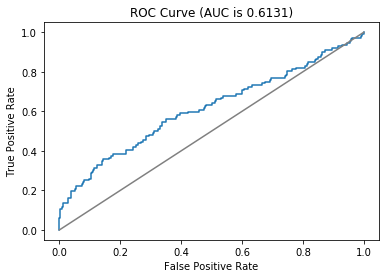

<IPython.core.display.Javascript object>

In [24]:
y_prob = poly_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], c="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (AUC is {auc:.4f})")
plt.show()

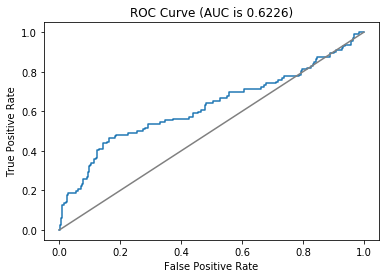

<IPython.core.display.Javascript object>

In [25]:
y_prob = rbf_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], c="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (AUC is {auc:.4f})")
plt.show()

In [26]:
grid = [{"degree": [1, 2, 3, 4, 5, 6, 7, 9]}]

poly_model = GridSearchCV(SVC(kernel="poly", probability=True), grid, verbose=1)
poly_model.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   31.0s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='poly', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'degree': [1, 2, 3, 4, 5, 6, 7, 9]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

<IPython.core.display.Javascript object>

In [27]:
poly_model.best_params_

{'degree': 2}

<IPython.core.display.Javascript object>

In [28]:
print(poly_model.score(X_train, y_train))
print(poly_model.score(X_test, y_test))

0.8488372093023255
0.8483606557377049


<IPython.core.display.Javascript object>

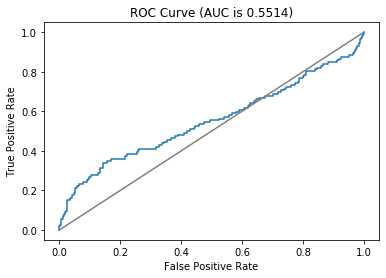

<IPython.core.display.Javascript object>

In [29]:
y_prob = poly_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], c="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (AUC is {auc:.4f})")
plt.show()

In [30]:
y_pred = poly_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       620
           1       1.00      0.01      0.02       112

    accuracy                           0.85       732
   macro avg       0.92      0.50      0.47       732
weighted avg       0.87      0.85      0.78       732



<IPython.core.display.Javascript object>

In [31]:
y_test.value_counts()

0    620
1    112
Name: TenYearCHD, dtype: int64

<IPython.core.display.Javascript object>

In [32]:
1 - (112 / 620)

0.8193548387096774

<IPython.core.display.Javascript object>